In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [21]:
img = cv2.imread('Dataset/Not Cropped/Chelsea Islan/24.jpg')
img.shape

(299, 168, 3)

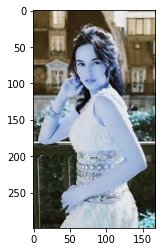

In [22]:
plt.imshow(img)

In [23]:
# Membuat image menjadi gray 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Pada 
gray.shape

(299, 168)

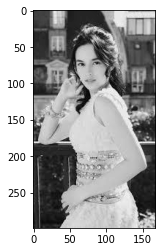

In [24]:
plt.imshow(gray,cmap='gray')

In [25]:
eye_cascade = cv2.CascadeClassifier('C:\\Users\\Administrator\\OneDrive\\Documents\\INI KULIAH BUKAN MAIN MAIN\\Modul Python\\Driver\haarcascades\\haarcascade_eye.xml')
face_cascade = cv2.CascadeClassifier('C:\\Users\\Administrator\\OneDrive\\Documents\\INI KULIAH BUKAN MAIN MAIN\\Modul Python\\Driver\haarcascades\\haarcascade_frontalface_default.xml')

In [26]:
def cek_image_path(path):
    try:
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        face = face_cascade.detectMultiScale(gray, 1.1, 4)
        if len(face) == 1:
            for (x,y,w,h) in face:
                face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
                roi_gray = gray[y:y+h,x:x+w]
                roi_color = face_img[y:y+h,x:x+w]
                eyes = eye_cascade.detectMultiScale(roi_gray)
                if len(eyes) >= 2:
                    return roi_color
    except:
        pass

In [27]:
# Membuat Path 
our_folder= os.getcwd()
dataset_folder = os.path.join(our_folder,'Dataset\\Not Cropped')
img_dirs = []
for entry in os.scandir(dataset_folder):
    if entry.is_dir():
        img_dirs.append(entry.path)


In [32]:
# Membuat Cropp-an Muka Setiap orangnya
crop_path = os.path.join(our_folder,'Dataset\\Cropped\\')
cropped_image_dirs = []
artist_file_name_dict = {}

for img_dir in img_dirs:
    count = 1
    peakyblinder_char_name = img_dir.split('\\')[-1]
    artist_file_name_dict[peakyblinder_char_name]=[]
    for entry in os.scandir(img_dir):
        roi_color = cek_image_path(entry.path)
        if roi_color is not None:
            cropped_folder = crop_path + peakyblinder_char_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)

            cropped_file_name = peakyblinder_char_name +str(count) + '.png'
            cropped_file_path = cropped_folder + '\\' + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            artist_file_name_dict[peakyblinder_char_name].append(cropped_file_path)
            count+=1


In [33]:
import pywt
import cv2
# Penggunaan ini memudahkan komputer untuk melakukan Klasifikasi
def w2d(img, mode='haar', level=1):
    imArray = img
    # Ubah menjadi warna abu-abu
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    # Ubah menjadi tipe data float
    imArray = np.float32(imArray)
    imArray /= 255
    # Mengkomputasi Koefisien
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    # Proses koefisien
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    # Rekontruksi
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H) 

    return imArray_H

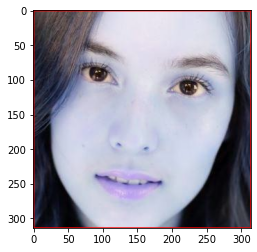

In [34]:
# Photo sebelum perubahan
test_img = cv2.imread('Dataset/Cropped/Chelsea Islan/Chelsea Islan10.png')
plt.imshow(test_img,cmap='gray')

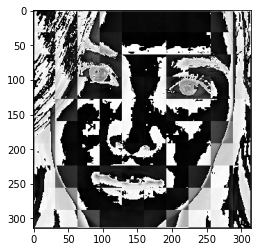

In [35]:
# Contoh perubahan
test_img = cv2.imread('Dataset/Cropped/Chelsea Islan/Chelsea Islan10.png')
test_img = w2d(test_img,'db1',5)
plt.imshow(test_img,cmap='gray')

In [36]:
class_dic = {}
count = 0
for artis in artist_file_name_dict.keys():
    class_dic[artis] = count
    count+=1
class_dic

{'Chelsea Islan': 0,
 'Jennifer Aniston': 1,
 'Lewis Hamilton': 2,
 'Taehyung': 3,
 'Tommy Shelby': 4}

In [40]:
X = []
y = []

for artist_name, training_files in artist_file_name_dict.items():
    for training_img in training_files:
        img = cv2.imread(training_img)
        if img is None :
            continue
        # Di buat semuanya skalanya sama
        scalled_raw_img = cv2.resize(img,(32,32))
        img_har = w2d(img,'db1',5)
        scalled_raw_har= cv2.resize(img_har,(32,32))
        # Mengstackan 2 image menjadi atas bawah
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_raw_har.reshape(32*32,1))) #Scalled raw img di * 3 karena berwarna
        X.append(combined_img)
        y.append(class_dic[artist_name])

print(len(X))
print(len(y))


4096
289


In [45]:
# Melihat apakah jumlahnya sama
print(len(X[0]))
print(len(y))

4096
289


In [52]:
# Reshape X 
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape


(289, 4096)

Data Cleaning is already Done. Now let's started to train our model

We Will use SVM with rbf kernel tuned with heuristic finetuning

In [55]:
# Library yang digunakan
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 2)

pipe = Pipeline([('scaler',StandardScaler()), ('svc',SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.8493150684931506

In [59]:
print(len(X_test))
print(len(X_train))

73
216


In [60]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        19
           1       0.94      0.80      0.86        20
           2       0.85      0.92      0.88        12
           3       1.00      0.73      0.85        15
           4       0.71      0.71      0.71         7

    accuracy                           0.85        73
   macro avg       0.85      0.83      0.83        73
weighted avg       0.87      0.85      0.85        73



Let's use GridSearch to try out different models with different paramets. 
Goal is to come up with best model with best fine tuned parameters

In [61]:
 from sklearn import svm
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.linear_model import LogisticRegression
 from sklearn.pipeline import make_pipeline
 from sklearn.model_selection import GridSearchCV

In [69]:
model_params = {
    'svm' : {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C' : [1,10,100,1000],
            'svc__kernel' : ['rbf','linear'],
            
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1,5,10]
        }
    },
    'logistic_regression' :{
        'model' : LogisticRegression(solver='liblinear',multi_class='auto'),
        'params' :{
            'logisticregression__C' : [1,5,10]
        }
    }
}

In [71]:
import pandas as pd 
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
        })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.833298,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.731184,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.838266,{'logisticregression__C': 5}


In [72]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [77]:
print(f"SVM = {best_estimators['svm'].score(X_test,y_test):.3f}")
print(f"Random Forest = {best_estimators['random_forest'].score(X_test,y_test):.3f}")
print(f"Logistic Regression = {best_estimators['logistic_regression'].score(X_test,y_test):.3f}")

SVM = 0.849
Random Forest = 0.712
Logistic Regression = 0.863


In [78]:
from sklearn.metrics import confusion_matrix
best_clf_svm = best_estimators['svm']
best_clf_logistic_regression = best_estimators['logistic_regression']
cm_svm = confusion_matrix(y_test, best_clf_svm.predict(X_test))
cm_lr = confusion_matrix(y_test, best_clf_logistic_regression.predict(X_test))

Text(42.0, 0.5, 'Truth')

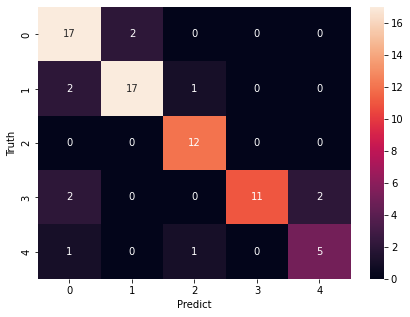

In [80]:
import seaborn as sn 
plt.figure(figsize=(7,5))
sn.heatmap(cm_svm,annot=True)
plt.xlabel('Predict')
plt.ylabel('Truth')

Text(42.0, 0.5, 'Truth')

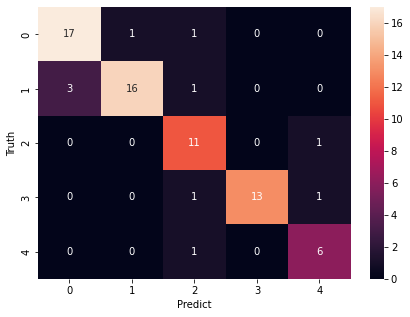

In [81]:
import seaborn as sn 
plt.figure(figsize=(7,5))
sn.heatmap(cm_lr,annot=True)
plt.xlabel('Predict')
plt.ylabel('Truth')

In [82]:
# i think, the best of our model is SVM, because as you can see on Confussion Matrix
# So i'm just gonna save SVM instead
import joblib
import json
# Save Our model as a pickle in a file
joblib.dump(best_clf_svm,'model_fix.pkl')
# And dont forget to save our class dictionary as well is gonna useful for deploying
with open("class_dict.json","w") as f:
    f.write(json.dumps(class_dic))
